In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

### Load data

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### Remove constant columns

In [5]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

#### Remove duplicated columns

In [6]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [7]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

### Feature selections

In [38]:
Xdf_tr = df_train.iloc[:,1:-1]
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 20 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]

In [39]:
selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]

Chi2 & F_classif selected 46 features
Chi2 & F_classif selected 46 features


In [40]:
from sklearn import preprocessing
#X_tr = df_train[features].as_matrix()
X_tr = preprocessing.scale(df_train[features].as_matrix())

t_tr = df_train['TARGET'].as_matrix()

In [41]:
# length of dataset
len_tr = len(X_tr)

# classifier
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.03, nthread=4, 
                        subsample=0.95, colsample_bytree=0.85, seed=4242)

X_fit, X_eval, y_fit, y_eval= train_test_split(X_tr, t_tr, test_size=0.3)

# fitting
clf.fit(X_tr, t_tr, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])

print('Overall AUC:', roc_auc_score(t_tr, clf.predict_proba(X_tr)[:,1]))

Will train until validation_0 error hasn't decreased in 20 rounds.
[0]	validation_0-auc:0.802800
Will train until validation_0 error hasn't decreased in 20 rounds.
[0]	validation_0-auc:0.802800
[1]	validation_0-auc:0.812905
[2]	validation_0-auc:0.813840
[1]	validation_0-auc:0.812905
[2]	validation_0-auc:0.813840
[3]	validation_0-auc:0.815897
[4]	validation_0-auc:0.816479
[3]	validation_0-auc:0.815897
[4]	validation_0-auc:0.816479
[5]	validation_0-auc:0.817847
[6]	validation_0-auc:0.812878
[5]	validation_0-auc:0.817847
[6]	validation_0-auc:0.812878
[7]	validation_0-auc:0.808675
[8]	validation_0-auc:0.810169
[7]	validation_0-auc:0.808675
[8]	validation_0-auc:0.810169
[9]	validation_0-auc:0.813441
[10]	validation_0-auc:0.809698
[9]	validation_0-auc:0.813441
[10]	validation_0-auc:0.809698
[11]	validation_0-auc:0.808584
[12]	validation_0-auc:0.809141
[11]	validation_0-auc:0.808584
[12]	validation_0-auc:0.809141
[13]	validation_0-auc:0.811918
[14]	validation_0-auc:0.814325
[13]	validation_0-

('Overall AUC:', 0.84549155966127976)
('Overall AUC:', 0.84549155966127976)


[349]	validation_0-auc:0.843382
[349]	validation_0-auc:0.843382


In [42]:
id_test = df_test['ID']

#X_test = df_test[features].as_matrix()
X_test = preprocessing.scale(df_test[features].as_matrix())

In [43]:
t_pred=clf.predict_proba(X_test)[:,1]

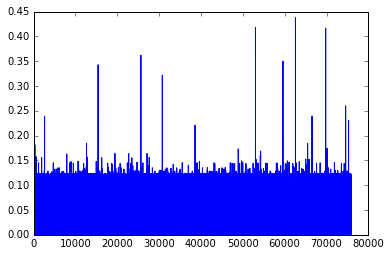

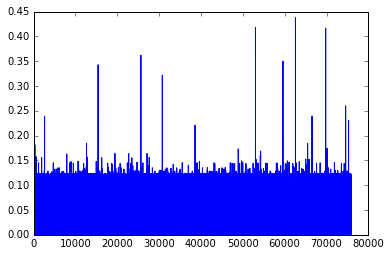

In [44]:
plt.plot(t_pred)

In [45]:
submission = pd.DataFrame({"ID":id_test, "TARGET": t_pred})
submission.to_csv("submission.csv", index=False)